In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = ['.'] + sorted(list(set(''.join(words))))

In [6]:
stoi = {s:i for i, s in enumerate(chars)}
itos = {i:s for s, i in stoi.items()}

In [180]:
# Good, fast-ish (couple minutes) results with 4, 15, 300, 128
BLOCK_SIZE = 4
EMBEDDING_DIMENSION = 30
HIDDEN_LAYER_NEURONS = 120
BATCH_SIZE = 200

In [8]:
# build the dataset

block_size = BLOCK_SIZE  # context length: how many chars are we gonna use to predict the next?
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [9]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 4]), torch.int64, torch.Size([228146]), torch.int64)

In [10]:
# build the dataset

def build_dataset(words):
    block_size = BLOCK_SIZE  # context length: how many chars are we gonna use to predict the next?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [11]:
C = torch.randn(27, EMBEDDING_DIMENSION)

In [12]:
C[5]

tensor([ 2.5699, -0.1919, -1.2358, -1.1476,  0.0893,  0.6888, -1.6017, -1.4940,
         1.6630, -0.3498, -0.0027,  0.0618, -0.3013, -0.8605,  0.2623])

In [13]:
emb = C[X]
emb.shape

torch.Size([228146, 4, 15])

In [14]:
# 6 = 3*2. We are trying to create the hidden layer. It will have 6 inputs, since it will take in the
# 3 characters, each embedded in a 2-dimensional vector. so like 'a' might be represented as
# (-0.5, 0.12). We have 3, so that's 6 numbers that need to be connected into the hidden layer as
# inputs.
# We then have 100 neurons in this hidden layer - that's up to us. Hyperparameter.
W1 = torch.randn((BLOCK_SIZE * EMBEDDING_DIMENSION, HIDDEN_LAYER_NEURONS))
b1 = torch.randn(HIDDEN_LAYER_NEURONS)

In [15]:
# We want to do emb @ W1 + b1, but cannot since (32, 3, 2) can't matrix multiply by (6, 100).
# We want to convert (32, 3, 2) into (32, 6) - essentially, concatenating the embeddings of the 3
# characters into a list of 6 floats ('features'?).

In [16]:
# Think of unbind as looping through that dimension, returning its contents. So for input '..e',
# which is at dimension 1, we get:
# [embedding of '.', embedding of '.', embedding of 'e'].
# With torch.cat, we then put them together. Since it is still per example (we still have dimension 0,
# i.e. each row, i.e. each input), we specify to concat the dimension of these embeddings -
# dimension 1 (of the unbinded tensor, which only has 2 dims).

In [17]:
torch.unbind(emb[1:2], dim=1)

(tensor([[-0.6505,  2.0504,  0.3965,  0.2614,  0.8845,  1.3129,  0.7236, -2.7266,
          -0.5811, -1.7779, -1.1818,  0.0915,  1.8210,  1.5940, -0.3204]]),
 tensor([[-0.6505,  2.0504,  0.3965,  0.2614,  0.8845,  1.3129,  0.7236, -2.7266,
          -0.5811, -1.7779, -1.1818,  0.0915,  1.8210,  1.5940, -0.3204]]),
 tensor([[-0.6505,  2.0504,  0.3965,  0.2614,  0.8845,  1.3129,  0.7236, -2.7266,
          -0.5811, -1.7779, -1.1818,  0.0915,  1.8210,  1.5940, -0.3204]]),
 tensor([[ 2.5699, -0.1919, -1.2358, -1.1476,  0.0893,  0.6888, -1.6017, -1.4940,
           1.6630, -0.3498, -0.0027,  0.0618, -0.3013, -0.8605,  0.2623]]))

In [18]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([228146, 60])

In [19]:
# More simply, we can just directly ask pytorch to give us the tensor in a specific shape. Very
# efficient.

In [20]:
h = torch.tanh(emb.view(-1, BLOCK_SIZE * EMBEDDING_DIMENSION) @ W1 + b1)
h.shape

torch.Size([228146, 300])

In [21]:
W2 = torch.randn((HIDDEN_LAYER_NEURONS, 27))
b2 = torch.randn(27)

In [22]:
logits = h @ W2  + b2

In [23]:
logits.shape

torch.Size([228146, 27])

In [24]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [126]:
def calc_loss(logits, labels, *weights):
    # Haven't figured out regularisation working.
    # print(sum((w**2).sum() for w in weights))
    # print(0.0001*(sum((w**2).sum() for w in weights)))
    # print(F.cross_entropy(logits, labels))
    return F.cross_entropy(logits, labels) # + 0.0001*(sum((w**2).sum() for w in weights))

In [60]:
def calc_logits(emb, W1, W2, b1, b2, Wdirect):
    x = emb.view(-1, BLOCK_SIZE * EMBEDDING_DIMENSION)
    h = torch.tanh(x @ W1 + b1)
    return h @ W2 + b2 + x @ Wdirect

In [27]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 4]), torch.Size([182625]))

In [181]:
g = torch.Generator().manual_seed(11219391)
C = torch.randn(27, EMBEDDING_DIMENSION, generator=g)
W1 = torch.randn((BLOCK_SIZE * EMBEDDING_DIMENSION, HIDDEN_LAYER_NEURONS), generator=g)
b1 = torch.zeros(HIDDEN_LAYER_NEURONS)
W2 = torch.randn((HIDDEN_LAYER_NEURONS, 27), generator=g)
b2 = torch.zeros(27)
Wdirect = torch.randn((BLOCK_SIZE * EMBEDDING_DIMENSION, 27), generator=g)
parameters = [C, W1, b1, W2, b2, Wdirect]

In [182]:
sum(p.nelement() for p in parameters)

21837

In [183]:
for p in parameters:
    p.requires_grad = True

In [184]:
lre = torch.linspace(-3, 0, 1000)  # learning rate exponent
lrs = 10**lre

In [185]:
lri = []
lossi = []
stepi = []

In [186]:
print(f'{C.shape=}')
print(f'{Xtr.shape=}')
print(f'{torch.randint(0, Xtr.shape[0], (BATCH_SIZE,)).shape=}')
print(f'{Xtr[torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))].shape=}')
print(f'{C[Xtr[torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))]].shape=}')


C.shape=torch.Size([27, 30])
Xtr.shape=torch.Size([182625, 4])
torch.randint(0, Xtr.shape[0], (BATCH_SIZE,)).shape=torch.Size([200])
Xtr[torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))].shape=torch.Size([200, 4])
C[Xtr[torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))]].shape=torch.Size([200, 4, 30])


In [187]:
STEPS = 150000
FIRST_RUN = True
for i in range(STEPS):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2). 32 (BATCH_SIZE) examples, 3 letters per example, embedded in 2-dimensional vector
    logits = calc_logits(emb, W1, W2, b1, b2, Wdirect)
    loss = calc_loss(logits, Ytr[ix], W1, W2, Wdirect)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1
    if not FIRST_RUN or i > STEPS/2:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # stepi.append(i)
    # lossi.append(loss.log10().item())

In [188]:
emb = C[Xtr]
logits = calc_logits(emb, W1, W2, b1, b2, Wdirect)
loss = calc_loss(logits, Ytr, W1, W2, Wdirect)

loss.item()

2.080101251602173

In [189]:
emb = C[Xdev]
logits = calc_logits(emb, W1, W2, b1, b2, Wdirect)
loss = calc_loss(logits, Ydev, W1, W2, Wdirect)

loss.item()  # beat 2.17 yay already done

2.1193809509277344

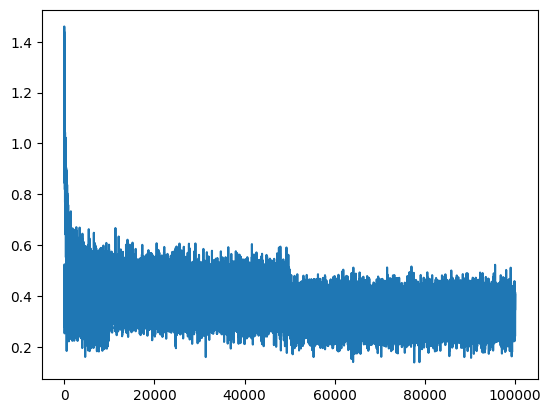

In [422]:
plt.plot(stepi, lossi)

In [115]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

oluels.
antrejanis.
lureevontelik.
iruntxon.
ronard.
roe.
oru.
rumus.
orron.
roncee.
kryncer.
roanralinir.
ron.
rungirikk.
luveer.
veles.
roxteelley.
rivos.
korgy.
yrunni.


In [ ]:
# Something to remember: when we roll our own logits->exp->probs, high positive numbers in the logits
# will cause issues, since e.g. e^100 is way too big (becomes inf). The way to fix this, and what
# pytorch does, is to subtract the higher number from every number in the logits, causing all of them
# to be 0 or lower. Negative numbers exponentiated are always fine (just small fractions, unless
# reallllly small ig). This subtraction does nothing to the end probabilities though - they're
# unaffected (maths probs checks out, haven't done it)